In [324]:
import glob
import numpy as np
import pandas as pd
import cv2
import random 
import math
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
from skimage import transform
from torch.autograd import Variable

In [252]:
class BeeDataset(Dataset):
    def __init__(self, data_dir, transforms=None, bw=False):
        self.data_dir = data_dir        
        self.transforms = transforms
        self.colormap = cv2.COLOR_BGR2GRAY if bw else cv2.COLOR_BGR2RGB
        
        self._setup_data()
    
    def _setup_labels(self, data_df):
        self.y_labels_source = data_df['health']
        
        unique_keys = np.sort(np.unique(self.y_labels_source))
        self.num_classes = len(unique_keys)
        self.key_to_idx = {ele : i for i, ele in enumerate(unique_keys)}
        self.idx_to_key = {val : key for key, val in self.key_to_idx.items()}
        
        self.y = [self.key_to_idx[key] for key in self.y_labels_source]
   
    def _setup_data(self):
        # Setup y (target ouput)
        labels_csv = glob.glob(f"{self.data_dir}/*.csv")[0]
        data_df = pd.read_csv(labels_csv)
        self._setup_labels(data_df)
        
        # Setup X (model input)
        self.X_filenames = data_df['file']
        self.X_filepaths = [f"{self.data_dir}/bee_imgs/{f}" for f in self.X_filenames]
        
        self.num_files = len(self.X_filepaths)
        
    def __getitem__(self, idx):
        img = cv2.imread(self.X_filepaths[idx])
        img = cv2.cvtColor(img, self.colormap)
        
        y = self.y[idx]
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, y
    
    def __len__(self):
        return self.num_files
    

### Transformations for data augmentation

In [253]:
class CustomNormalize:
    def __call__(self, x):
        x = (x * 2) - 1
        return x

In [261]:
BW = True

In [262]:
bee_dir = '/Users/dieumynguyen/Datasets/HoneyBees'
transform_list = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),    
    transforms.ToTensor(),  # always need, div by 255 
    CustomNormalize()
])

# Wrapper around the data
# Could load data into np or a pointer/filepath
bee_data_src = BeeDataset(bee_dir, transforms=transform_list, bw=BW)

In [327]:
bee_data_src

### Splitting data

In [263]:
test_split = 0.2

indices = list(range(len(bee_data_src)))

# shuffle 
np.random.shuffle(indices)

num_test = int(len(indices) * test_split)
len(indices), num_test

(5172, 1034)

In [264]:
test_set_indices = indices[:num_test]
train_set_indices = indices[num_test:]

In [265]:
train_sampler = SubsetRandomSampler(train_set_indices)
test_sampler = SubsetRandomSampler(test_set_indices)

In [266]:
BATCH_SIZE = 4

In [267]:
train_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=train_sampler)
test_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=test_sampler)


In [328]:
# Wrapper around dataset wrapper
# Calls __getitem__ for each iteration (calls batch_size times)
# Builds into X, y
for X, y in train_dataloader:
    print("Here")
    break

Here


Text(0.5, 1.0, 'healthy                     few varrao, hive beetles                     healthy                     healthy                  ')

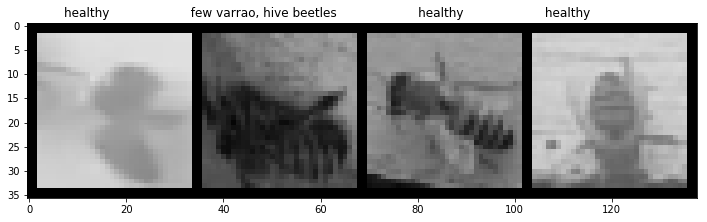

In [325]:
xxx = (X + 1) / 2.0
grid_img = utils.make_grid(xxx)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_img.permute(1,2,0))
recovered_labels = [bee_data_src.idx_to_key[ele.item()] for ele in y]
title_str = ""
for recovered_label in recovered_labels:
    title_str += f"{recovered_label}                     "
title_str = title_str[:-3]
plt.title(title_str)

### CNN

In [278]:
class CNN(nn.Module):
    def __init__(self, num_classes, num_in_channels):
        '''
        In this constructor, define layers using provided modiles from nn package.
        A Sequential is defined by a sequence of a layer, normalization, activation, pooling.
        '''
        super(CNN, self).__init__()
                
        self.layer1 = nn.Sequential(
            # Conv layer: nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride=1)
            nn.Conv2d(num_in_channels, 16, kernel_size=5, padding=2),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        # After 2 conv layers & activations, end network with Fully Connected layer 
        # that outputs to 10 classes
        N = 8
        M = 8
        self.fc = nn.Linear(N*M*32, num_classes)
        
    def forward(self, x):
        ''' 
        This function is called on the net for a set of inputs,
        and it passes that input through different layers defined above.
        
        For ex, we pass x through first layer, pass its output through
        second layer, and pass that through the final FC layer to get 
        final output. 
        '''
        out = self.layer1(x)
        out = self.layer2(out)
        
        # Reshape output to match dims required for final layer
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        
        return out
        

In [313]:
num_epochs = 100
learning_rate = 0.001

In [314]:
# Instantiate an instance of the conv net
num_classes = bee_data_src.num_classes
num_in_channels = 1 if BW else 3
cnn = CNN(num_classes=num_classes, num_in_channels=num_in_channels)

# Loss function and optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [298]:
losses = []
test_accuracies = []

In [317]:
try:
    for epoch_i in range(num_epochs):
        cnn.train()
        batch_losses = []
        for batch_i, (images, labels) in enumerate(train_dataloader):

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Add loss values to array to print out progress of training
            batch_losses.append(loss.data) 

            if (batch_i+1) % 100 == 0:
                num_batches = len(train_dataloader)
                print(f'Epoch: {epoch_i+1}/{num_epochs}, Batch: {batch_i+1}/{num_batches}, Loss: {loss.data:.6f}')

        if epoch_i % 1 == 0:
            test_acc = evaluate_cnn()
            test_accuracies.append((epoch_i, test_acc))
            
        losses.append(np.mean(batch_losses))
except KeyboardInterrupt:
    print("\nEnding Early.")

Epoch: 1/100, Batch: 100/1035, Loss: 0.401141
Epoch: 1/100, Batch: 200/1035, Loss: 0.648509
Epoch: 1/100, Batch: 300/1035, Loss: 0.688974
Epoch: 1/100, Batch: 400/1035, Loss: 0.849803
Epoch: 1/100, Batch: 500/1035, Loss: 0.571305
Epoch: 1/100, Batch: 600/1035, Loss: 0.831254
Epoch: 1/100, Batch: 700/1035, Loss: 0.930239
Epoch: 1/100, Batch: 800/1035, Loss: 0.458604
Epoch: 1/100, Batch: 900/1035, Loss: 0.515769
Epoch: 1/100, Batch: 1000/1035, Loss: 0.489305
Test accuracy: 79%
Epoch: 2/100, Batch: 100/1035, Loss: 0.800538
Epoch: 2/100, Batch: 200/1035, Loss: 0.190989
Epoch: 2/100, Batch: 300/1035, Loss: 0.734583
Epoch: 2/100, Batch: 400/1035, Loss: 0.290738
Epoch: 2/100, Batch: 500/1035, Loss: 0.906479
Epoch: 2/100, Batch: 600/1035, Loss: 0.061460
Epoch: 2/100, Batch: 700/1035, Loss: 0.860945
Epoch: 2/100, Batch: 800/1035, Loss: 0.757730
Epoch: 2/100, Batch: 900/1035, Loss: 0.298766
Epoch: 2/100, Batch: 1000/1035, Loss: 1.662793
Test accuracy: 82%
Epoch: 3/100, Batch: 100/1035, Loss: 0.4

Test accuracy: 87%
Epoch: 18/100, Batch: 100/1035, Loss: 0.032063
Epoch: 18/100, Batch: 200/1035, Loss: 0.060539
Epoch: 18/100, Batch: 300/1035, Loss: 0.200067
Epoch: 18/100, Batch: 400/1035, Loss: 0.001122
Epoch: 18/100, Batch: 500/1035, Loss: 0.004795
Epoch: 18/100, Batch: 600/1035, Loss: 0.001917
Epoch: 18/100, Batch: 700/1035, Loss: 0.008009
Epoch: 18/100, Batch: 800/1035, Loss: 0.001781
Epoch: 18/100, Batch: 900/1035, Loss: 0.001764
Epoch: 18/100, Batch: 1000/1035, Loss: 0.000064
Test accuracy: 88%
Epoch: 19/100, Batch: 100/1035, Loss: 0.003486
Epoch: 19/100, Batch: 200/1035, Loss: 0.017879
Epoch: 19/100, Batch: 300/1035, Loss: 0.164951
Epoch: 19/100, Batch: 400/1035, Loss: 0.019279
Epoch: 19/100, Batch: 500/1035, Loss: 0.000811
Epoch: 19/100, Batch: 600/1035, Loss: 0.030562
Epoch: 19/100, Batch: 700/1035, Loss: 0.001113
Epoch: 19/100, Batch: 800/1035, Loss: 0.301953
Epoch: 19/100, Batch: 900/1035, Loss: 0.010780
Epoch: 19/100, Batch: 1000/1035, Loss: 0.141279
Test accuracy: 86%
E

Epoch: 34/100, Batch: 900/1035, Loss: 0.000446
Epoch: 34/100, Batch: 1000/1035, Loss: 0.000565
Test accuracy: 84%
Epoch: 35/100, Batch: 100/1035, Loss: 0.023009
Epoch: 35/100, Batch: 200/1035, Loss: 0.333388
Epoch: 35/100, Batch: 300/1035, Loss: 0.002185
Epoch: 35/100, Batch: 400/1035, Loss: 0.001144
Epoch: 35/100, Batch: 500/1035, Loss: 0.000351
Epoch: 35/100, Batch: 600/1035, Loss: 0.000020
Epoch: 35/100, Batch: 700/1035, Loss: 0.008464
Epoch: 35/100, Batch: 800/1035, Loss: 0.000804
Epoch: 35/100, Batch: 900/1035, Loss: 0.000682
Epoch: 35/100, Batch: 1000/1035, Loss: 0.014275
Test accuracy: 86%
Epoch: 36/100, Batch: 100/1035, Loss: 0.000047
Epoch: 36/100, Batch: 200/1035, Loss: 0.014949
Epoch: 36/100, Batch: 300/1035, Loss: 0.000619
Epoch: 36/100, Batch: 400/1035, Loss: 0.000246
Epoch: 36/100, Batch: 500/1035, Loss: 0.000006
Epoch: 36/100, Batch: 600/1035, Loss: 0.000440
Epoch: 36/100, Batch: 700/1035, Loss: 0.008281
Epoch: 36/100, Batch: 800/1035, Loss: 0.000044
Epoch: 36/100, Batch

Epoch: 51/100, Batch: 700/1035, Loss: 0.014896
Epoch: 51/100, Batch: 800/1035, Loss: 0.001695
Epoch: 51/100, Batch: 900/1035, Loss: 0.000785
Epoch: 51/100, Batch: 1000/1035, Loss: 0.000192
Test accuracy: 85%
Epoch: 52/100, Batch: 100/1035, Loss: 0.000118
Epoch: 52/100, Batch: 200/1035, Loss: 0.028366
Epoch: 52/100, Batch: 300/1035, Loss: 0.060229
Epoch: 52/100, Batch: 400/1035, Loss: 0.023254
Epoch: 52/100, Batch: 500/1035, Loss: 0.000412
Epoch: 52/100, Batch: 600/1035, Loss: 0.000557
Epoch: 52/100, Batch: 700/1035, Loss: 0.000777
Epoch: 52/100, Batch: 800/1035, Loss: 0.000027
Epoch: 52/100, Batch: 900/1035, Loss: 0.001785
Epoch: 52/100, Batch: 1000/1035, Loss: 0.026994
Test accuracy: 86%
Epoch: 53/100, Batch: 100/1035, Loss: 0.000004
Epoch: 53/100, Batch: 200/1035, Loss: 0.000002
Epoch: 53/100, Batch: 300/1035, Loss: 0.000002
Epoch: 53/100, Batch: 400/1035, Loss: 0.020386
Epoch: 53/100, Batch: 500/1035, Loss: 0.008169
Epoch: 53/100, Batch: 600/1035, Loss: 0.000121
Epoch: 53/100, Batch

Epoch: 68/100, Batch: 500/1035, Loss: 0.001308
Epoch: 68/100, Batch: 600/1035, Loss: 0.000000
Epoch: 68/100, Batch: 700/1035, Loss: 0.024296
Epoch: 68/100, Batch: 800/1035, Loss: 0.008804
Epoch: 68/100, Batch: 900/1035, Loss: 0.000160
Epoch: 68/100, Batch: 1000/1035, Loss: 0.000002
Test accuracy: 83%
Epoch: 69/100, Batch: 100/1035, Loss: 0.000468

Ending Early.


In [320]:
LOAD_MODEL = False
if LOAD_MODEL:
    load_dict = torch.load("test.pt")
    model_dict = load_dict['model']
    optim_dict = load_dict['optim']
    
    cnn.load_state_dict(model_dict)
    optimizer.load_state_dict(optim_dict)

In [322]:
SAVE_MODEL = False
if SAVE_MODEL:
    save_dict = {
        "model"  : cnn.state_dict(),
        "optim"  : optimizer.state_dict()
    }
    torch.save(save_dict, "test.pt")

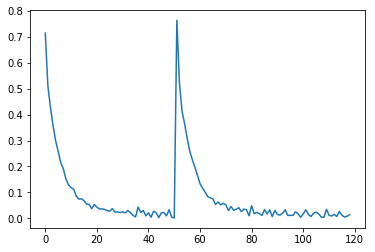

In [323]:
plt.plot(losses)

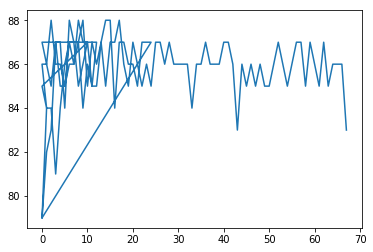

In [319]:
test_accuracies_np = np.array(test_accuracies)
plt.plot(test_accuracies_np[:,0], test_accuracies_np[:,1])

In [295]:
def evaluate_cnn():
    cnn.eval()
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100*correct/total
    print(f"Test accuracy: {accuracy}%")
    return accuracy

### To try:
1. Fully connected: 
2. Conv net (now): 
    - Now
    - Import resnet & train
3. Fully conv net